In [1]:
import numpy as np
import pandas as pd
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
! mkdir ./data

In [4]:
Data = pd.read_csv('./data/ratings_Electronics.csv', names =
                   ['user_id', 'product_id', 'rating', 'timestamp'])

In [5]:
Data.head(3)

,user_id,product_id,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600


In [6]:
Data.shape

(7824482, 4)

In [7]:
subset = Data.iloc[:1000000, 0:]

In [8]:
subset.describe()['rating']

count    1000000.000000
mean           3.973620
std            1.399741
min            1.000000
25%            3.000000
50%            5.000000
75%            5.000000
max            5.000000
Name: rating, dtype: float64

In [9]:
Data.isnull().sum()

user_id       0
product_id    0
rating        0
timestamp     0
dtype: int64

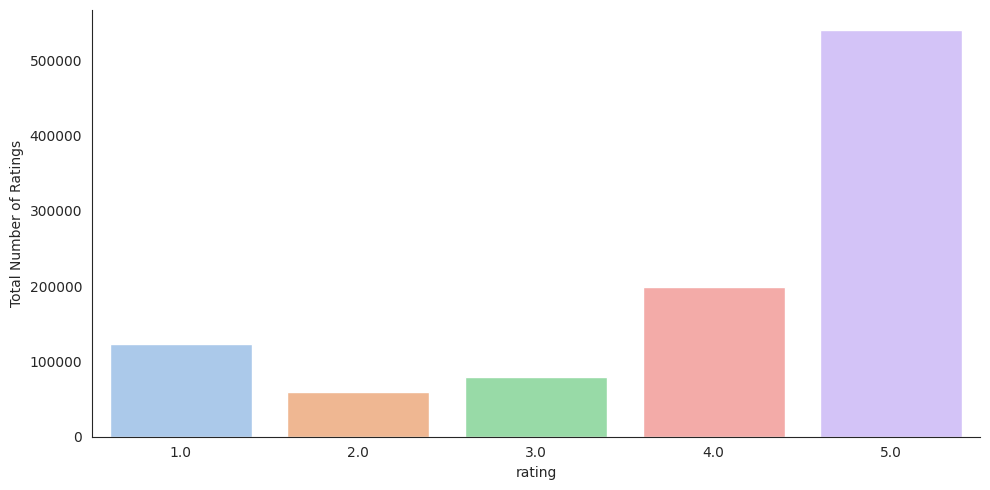

In [10]:
with sns.axes_style('white'):
  g = sns.catplot(x= 'rating', data = subset, aspect = 2.0, kind = 'count'
  , palette='pastel')
  g.set_ylabels("Total Number of Ratings")

Analyzing the rating

In [11]:
#rating given by the user
rating_given_by_user = subset.groupby(['user_id'])['rating'].count().sort_values(ascending = False)

In [12]:
rating_given_by_user.head()

user_id
A5JLAU2ARJ0BO     409
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      138
AT6CZDCP4TRGA     125
Name: rating, dtype: int64

In [13]:
rating_given_by_user.describe()

count    754153.000000
mean          1.325991
std           1.372250
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         409.000000
Name: rating, dtype: float64

Users given 50 or more ratings

In [14]:
df_50 = subset.groupby(['product_id']).filter(lambda x: x['rating'].count() >= 50)

In [15]:
df_50.dtypes

user_id        object
product_id     object
rating        float64
timestamp       int64
dtype: object

In [16]:
df_50 = df_50.drop(columns = ['timestamp'])

In [17]:
df_50.head()

,user_id,product_id,rating
183,A1BKC6B7YHYTVV,0972683275,4.0
184,AWVFSIB42LHKJ,0972683275,4.0
185,A36MQBNADRH8YY,0972683275,5.0
186,A3SRXMPLAEZ6DP,0972683275,4.0
187,A20XXTXWF2TCPY,0972683275,5.0


In [18]:
df_50.shape

(642623, 3)

In [19]:
df_50.groupby(['product_id'])['rating'].mean().head()

product_id
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: rating, dtype: float64

In [20]:
average_rating_count = pd.DataFrame(df_50.groupby(['product_id'])['rating'].mean())

In [21]:
average_rating_count['total_ratings'] = pd.DataFrame(df_50.groupby(['product_id'])['rating'].count())

<Axes: >

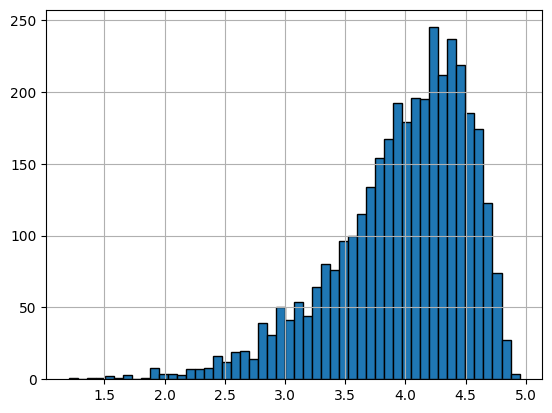

In [22]:
plt.rcParams['patch.force_edgecolor'] = True
average_rating_count['rating'].hist(bins= 50)

Collaberative Filtering (item-item recommendation)

In [23]:
#!pip3 install surprise

Model-based collaborative filtering system

*  these methods are based on ML and data mining techniques.
* we could use existing user-item interactions to train a model to predict the top-5 items that a user might like the most.



In [24]:
df_10000= df_50.head(10000)
ratings_pivot = df_10000.pivot_table(values = 'rating',
                                     index = 'user_id',
                                     columns = 'product_id', fill_value = 0)
ratings_pivot.head()

product_id,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
user_id,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# preprocessing
Normalize the ratings first by subtracting the row means from the ratings. And fill with zeros. We do this so the ratings are centered between 0 and 1.

In [25]:
average_ratings = ratings_pivot.mean(axis = 1)
ratings_pivot_centered = ratings_pivot.sub(average_ratings, axis = 0)
ratings_pivot_norma = ratings_pivot_centered.fillna(0)

In [26]:
from scipy.sparse import csc_matrix

# Convert DataFrame to a sparse matrix
ratings_sparse = csc_matrix(ratings_pivot_centered.values)

Find out the top 5 products that User A030530627MK66BD8V4LN would like.

In [27]:
# decomposing the matrix
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(ratings_sparse)
print(U.shape)

(9832, 6)


In [28]:
sigma.shape

(6,)

In [29]:
sigma = np.diag(sigma)

In [30]:
print(sigma)

[[ 79.93494363   0.           0.           0.           0.
    0.        ]
 [  0.          83.7019858    0.           0.           0.
    0.        ]
 [  0.           0.          85.0773974    0.           0.
    0.        ]
 [  0.           0.           0.          86.24625471   0.
    0.        ]
 [  0.           0.           0.           0.          88.07770258
    0.        ]
 [  0.           0.           0.           0.           0.
  147.22333778]]


In [31]:
recalculated_ratings = np.dot(np.dot(U, sigma), Vt)


In [32]:
denormalized_ratings = recalculated_ratings * average_ratings.values.reshape(-1, 1)
print(denormalized_ratings)

[[-2.56525650e-03 -6.05577667e-03 -3.57314799e-03 ... -3.20436110e-03
  -3.30674998e-03 -3.17639550e-03]
 [-4.22939267e-03  4.60448849e-04  3.55821070e-04 ...  3.39862015e-04
   3.49247180e-04  3.37066586e-04]
 [ 3.24605058e-01 -4.92647854e-03 -4.34070930e-03 ... -4.21724156e-03
  -4.25526249e-03 -4.20941137e-03]
 ...
 [-2.78698992e-03  3.31097924e-04  2.53623751e-04 ...  2.41854568e-04
   2.48600897e-04  2.39846547e-04]
 [-1.80427853e-04  2.20826709e-05  1.55972822e-05 ...  1.46063892e-05
   1.50148684e-05  1.44830125e-05]
 [-4.10209066e-03  4.26584775e-04  3.29077686e-04 ...  3.14144354e-04
   3.22760963e-04  3.11590343e-04]]


In [33]:
calc_pred_ratings_df = pd.DataFrame(denormalized_ratings, index = ratings_pivot.index, columns = ratings_pivot.columns)

In [34]:
# this is the top 5 products user A030530627MK66BD8V4LN would enjoy
calc_pred_ratings_df.loc['A030530627MK66BD8V4LN'].sort_values(ascending = False)

product_id
0972683275    0.207747
B000001OM5   -0.002559
B00000J1V5   -0.002565
B00000J0D8   -0.002586
B00000J05A   -0.002614
                ...   
B00000JSGF   -0.003043
1400599997   -0.003044
1400501466   -0.003153
B00000J061   -0.003331
B00000JDF5   -0.003446
Name: A030530627MK66BD8V4LN, Length: 76, dtype: float64

#model performance
The traditional hold out cross valication does not apply to the recommendation systems model. It is because the model predicts a particular user's preference instead of predicting for just one user or the entire column of users. The hold out method for recommendation systems requires to use a block chunk of actual values for training and validating.

In [59]:
actual_values = ratings_pivot.iloc[: 20, :100 ].values
ratings_pivot.iloc[:20, :100] = np.nan
#generate predictions
predicted_values = calc_pred_ratings_df.iloc[:20, :100].values
#masking hold out set
mask = ~np.isnan(actual_values)
print(actual_values[mask])

[0 0 0 ... 0 0 0]


In [70]:
actual_values.shape

(1520,)

In [60]:
print(predicted_values[mask])

[-0.00256526 -0.00605578 -0.00357315 ...  0.00030997  0.00031872
  0.00030739]


In [61]:
#root mean square error
from sklearn.metrics import mean_squared_error
print(mean_squared_error(actual_values[mask],
                         predicted_values[mask],
                         squared= False))

0.4785408418004412


correlations by all items with the same item purchased by this customer based on items rated by other customers people who bought the same product

cosine similarities to find the most similar items

In [36]:
products_pivot = ratings_pivot_norma.T
most_similar = cosine_similarity(products_pivot)

In [37]:
cosine_similarity_df = pd.DataFrame(most_similar, index = products_pivot.index, columns = products_pivot.index)

In [38]:
cosine_similarity_df.head(3)

product_id,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
product_id,,,,,,,,,,,,,,,,,,,,,
0972683275,1.000000,-0.03499,-0.048119,-0.041417,-0.038785,-0.026532,-0.028823,-0.049425,-0.036353,-0.039347,...,-0.049336,-0.054620,-0.029514,-0.064679,-0.065451,-0.066442,-0.037135,-0.053607,-0.051503,-0.052639
1400501466,-0.034990,1.00000,0.001170,0.014949,-0.019088,-0.015558,-0.010582,-0.009738,-0.012480,-0.005266,...,-0.018466,-0.018686,-0.022354,-0.019119,-0.019206,-0.019442,-0.020007,-0.018598,-0.018729,-0.018102
1400501520,-0.048119,0.00117,1.000000,-0.000771,-0.014506,-0.027565,-0.021820,-0.008035,-0.005698,0.031410,...,-0.008443,-0.006322,-0.024515,-0.002306,-0.002090,-0.002027,-0.016869,-0.006649,-0.007870,-0.006253


# find similarities for a specific product

by looking the result below, the most similar products for id-1400501466 are 1400501776 and 1400501520.



In [39]:
cosine_similarity_series = cosine_similarity_df.loc['1400501466'].sort_values(ascending = False)

In [40]:
cosine_similarity_series

product_id
1400501466    1.000000
1400501776    0.014949
1400501520    0.001170
1400698987   -0.005266
1400532736   -0.009738
                ...   
B00000DM9W   -0.021538
B00000JI4F   -0.022354
B00000JDF5   -0.023511
B00000J1V5   -0.024314
0972683275   -0.034990
Name: 1400501466, Length: 76, dtype: float64

User KNN to predict a user (id: A0293130VTX2ZXA70JQS) who is likely to give a product rating (product ID: 0972683275)based on its 10 nearest neighbors

In [41]:
cosine_similarity_users = cosine_similarity(ratings_pivot_norma)

In [42]:
cosine_similarity_users_df = pd.DataFrame(cosine_similarity_users, index = ratings_pivot_norma.index, columns = ratings_pivot_norma.index)
cosine_similarity_users_df.head()

user_id,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
user_id,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,1.000000,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,...,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333
A0266076X6KPZ6CCHGVS,-0.013333,1.000000,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,...,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,1.000000,-0.013333,-0.013333,-0.013333,-0.013333
A0293130VTX2ZXA70JQS,-0.013333,-0.013333,1.000000,1.000000,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,...,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333
A030530627MK66BD8V4LN,-0.013333,-0.013333,1.000000,1.000000,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,...,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333
A0571176384K8RBNKGF8O,-0.013333,-0.013333,-0.013333,-0.013333,1.000000,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,...,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333,-0.013333


In [43]:
cosine_similar_user_series = cosine_similarity_users_df.loc['A0293130VTX2ZXA70JQS']
ordered_similaries = cosine_similar_user_series.sort_values(ascending = False)

In [44]:
#find top 10 similar users
nearest_neighbors = ordered_similaries[1:11].index
# extract the ratings from the top 10 users
neighbor_ratings = ratings_pivot.reindex(nearest_neighbors)
# calculate the average rating for a product
print(neighbor_ratings['0972683275'].mean())

3.0


In [45]:
ratings_pivot_norma

product_id,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
user_id,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,...,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632
A0266076X6KPZ6CCHGVS,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,...,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789
A0293130VTX2ZXA70JQS,4.934211,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,...,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789
A030530627MK66BD8V4LN,3.947368,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,...,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632
A0571176384K8RBNKGF8O,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,...,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZXP46IB63PU8,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,...,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789,-0.065789
AZYTSU42BZ7TP,-0.039474,-0.039474,-0.039474,-0.039474,-0.039474,2.960526,-0.039474,-0.039474,-0.039474,-0.039474,...,-0.039474,-0.039474,-0.039474,-0.039474,-0.039474,-0.039474,-0.039474,-0.039474,-0.039474,-0.039474
AZZGJ2KMWB7R,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,...,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632,-0.052632


User-User KNN

In [46]:
#ratings_pivot_norma.drop('0972683275', axis = 1, inplace = True)
target_user_x = ratings_pivot_norma.loc[['A0293130VTX2ZXA70JQS']]
target_user_x['0972683275'] = 0
print(target_user_x)

product_id            0972683275  1400501466  1400501520  1400501776  \
user_id                                                                
A0293130VTX2ZXA70JQS           0   -0.065789   -0.065789   -0.065789   

product_id            1400532620  1400532655  140053271X  1400532736  \
user_id                                                                
A0293130VTX2ZXA70JQS   -0.065789   -0.065789   -0.065789   -0.065789   

product_id            1400599997  1400698987  ...  B00000JFMK  B00000JHWX  \
user_id                                       ...                           
A0293130VTX2ZXA70JQS   -0.065789   -0.065789  ...   -0.065789   -0.065789   

product_id            B00000JI4F  B00000JII6  B00000JMUG  B00000JPPI  \
user_id                                                                
A0293130VTX2ZXA70JQS   -0.065789   -0.065789   -0.065789   -0.065789   

product_id            B00000JSGF  B00000JYLO  B00000JYWQ  B00000K135  
user_id                                       

In [47]:
ratings_pivot

product_id,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
user_id,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZXP46IB63PU8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AZYTSU42BZ7TP,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AZZGJ2KMWB7R,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
others_users_y = ratings_pivot['0972683275']

In [49]:
other_users_y = others_users_y[others_users_y !=0]

In [50]:
other_users_y

user_id
A0293130VTX2ZXA70JQS     5
A030530627MK66BD8V4LN    4
A1038957GWRBP375RU5T     5
A106YUCY4SVX1D           5
A1079KKA0AXSL3           4
                        ..
AZFF4CX9MQ4AE            5
AZM8PD2KBVXN5            5
AZO3DZAJ8S0D9            5
AZPT44204EODM            5
AZTC7YC8PKG39            5
Name: 0972683275, Length: 1051, dtype: int64

In [51]:
other_users_y.shape

(1051,)

In [52]:
other_users_x = ratings_pivot[others_users_y!= 0]

In [53]:
from sklearn.neighbors import KNeighborsRegressor
user_knn = KNeighborsRegressor(metric = 'cosine', n_neighbors= 10)
user_knn.fit(other_users_x, other_users_y)
user_user_pred = user_knn.predict(target_user_x)


KNeighborsRegressor(metric='cosine', n_neighbors=10)

In [54]:
print(user_user_pred)

[4.6]


In [55]:
actual_y = other_users_y['A0293130VTX2ZXA70JQS']

In [56]:
actual_y

5

model performance

In [57]:
from sklearn.metrics import mean_squared_error
import numpy as np
rmse = np.sqrt((5-4.6)**2)
print(rmse)

0.40000000000000036


In [71]:
#generate predictions
user_knn2 = KNeighborsRegressor(metric = 'cosine', n_neighbors = 10)
user_knn2.fit(other_users_x, other_users_y)
user_user_pred = user_knn2.predict(target_user_x)
#masking hold out set
mask = ~np.isnan(actual_values)

KNeighborsRegressor(metric='cosine', n_neighbors=10)

In [72]:
actual_values = actual_values.flatten()
user_user_pred = user_user_pred.flatten()

In [77]:
# Calculate RMSE
if len(actual_values) == len(user_user_pred) == len(mask):
  rmse = np.sqrt(mean_squared_error(actual_values[mask], user_user_pred[mask], squared=False))
  print(rmse)

In [78]:
rmse

array([-0.8874854 , -0.86133894, -1.11803399, -0.98294988, -0.86216781])